In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize

# Load the datasets
df_results = pd.read_csv("./2019-2020/detection-20192020.csv")
df_minutes = pd.read_csv('./2019-2020/minutes-20192020.csv')


# Filter out the invalid rows (based on the requirements)
df_results = df_results[(df_results['is_valid'] != False) & (df_results['confidence_score'] >= 75)]

unique_minutes = df_results['minute_id'].unique()
total_references = len(df_results)
print(f"{total_references} references found in {len(unique_minutes)} unique minutes.")
print(f"Contents of {len(df_minutes)} minutes found")

14976 references found in 281 unique minutes.
Contents of 281 minutes found


In [8]:
# Pick 4 random references
sampled_references = df_results.sample(n=4)
print("Sampled references:")
for index, row in sampled_references.iterrows():
    print(f"Minute ID: {row['minute_id']}, Reference: {row['text']}")

Sampled references:
Minute ID: h-tk-20192020-78-6, Reference: de Wiv
Minute ID: h-tk-20192020-11-3, Reference: een initiatiefwetsvoorstel
Minute ID: h-tk-20192020-42-9, Reference: de minister
Minute ID: h-tk-20192020-24-9-n1, Reference: de brief over het IPBES-rapport


In [3]:
# Calculate mean and median of number of references per minute
mean_references_per_minute = df_results.groupby('minute_id').size().mean()
median_references_per_minute = df_results.groupby('minute_id').size().median()
print(f"Mean references per minute: {mean_references_per_minute:.2f}")
print(f"Median references per minute: {median_references_per_minute:.2f}")

Mean references per minute: 53.30
Median references per minute: 49.00


In [6]:
# Show the distribution of detected reference types
df_results['reference_type'].value_counts()


reference_type
impl-local               6432
explicit-parl-doc        3640
impl-ext-parl-doc        2618
impl-ext-dossier         1084
impl-ext-third-party     1014
explicit-dossier          185
explicit-ext-parl-doc       3
Name: count, dtype: int64

Word count - min: 1, max: 58, median: 3.0, mean: 3.80
Log word count - min: 0.69, max: 4.08, median: 1.39, mean: 1.44


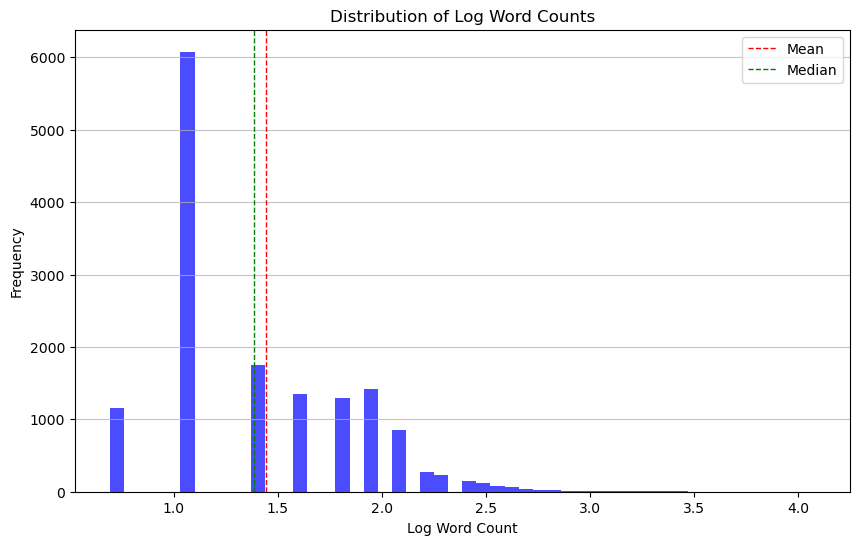

In [10]:
# Retrieve min, max, median, mean word count
word_counts = df_results['word_count']
min_word_count = word_counts.min()
max_word_count = word_counts.max()
median_word_count = word_counts.median()
mean_word_count = word_counts.mean()
print(f"Word count - min: {min_word_count}, max: {max_word_count}, median: {median_word_count}, mean: {mean_word_count:.2f}")

# Calculate log normally distributed word count
log_word_counts = np.log1p(word_counts)  # Adding 1 to avoid log(0)
log_min_word_count = log_word_counts.min()
log_max_word_count = log_word_counts.max()
log_median_word_count = log_word_counts.median()
log_mean_word_count = log_word_counts.mean()
print(f"Log word count - min: {log_min_word_count:.2f}, max: {log_max_word_count:.2f}, median: {log_median_word_count:.2f}, mean: {log_mean_word_count:.2f}")

# Plot the distribution of log word counts
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(log_word_counts, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Log Word Counts')
plt.xlabel('Log Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.axvline(log_mean_word_count, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(log_median_word_count, color='green', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()


In [9]:
# Calculate total sentence count
total_sentence_count = df_minutes['sentence_count'].sum()
print(f"Total sentence count across all minutes: {total_sentence_count}")

# Calculate total word count
total_word_count = df_minutes['word_count'].sum()
print(f"Total word count across all minutes: {total_word_count}")

Total sentence count across all minutes: 191009
Total word count across all minutes: 3318439


In [13]:
df_results['sent_tokenize'] =  df_results['sentence'].apply(sent_tokenize)
unique_sentences = df_results['sent_tokenize'].explode().nunique()

# Calculate how many references per sentence (each reference is seen as a sentence)
references_per_sentence = unique_sentences / total_sentence_count if total_sentence_count > 0 else 0
sentences_for_one_reference = 1 / references_per_sentence if references_per_sentence > 0 else float('inf')
# Round down as there can be multiple references in one sentence
print(f"Every {1 / references_per_sentence}  sentences has a reference.")

Every 13.005310819091715  sentences has a reference.


In [18]:

# Create a dataframe with all sentences and their reference status
df_all_sentences = pd.DataFrame(columns=['minute_id', 'sentence_index', 'sentence_text', 'has_reference', 'global_index'])

# Check if the file already exists to avoid overwriting
try:
    df_all_sentences = pd.read_csv('./2019-2020/sentences-from-20192020.csv')
    print(f"Loaded {len(df_all_sentences)} existing sentences from 'sentences-from-20192020.csv'.")
except:
    print(f"Creating new sentences file 'sentences-from-20192020.csv'.")
    for _, minute in df_minutes.iterrows():
        # Split text into sentences (you might need to adjust this based on your data)
        sentences =  sent_tokenize(minute['text'])
        all_sentences = df_all_sentences['sentence_text'].tolist()
        # Get references for this minute
        minute_refs = df_results[df_results['minute_id'] == minute['minute_id']]
        ref_sentences = set(minute_refs['sentence'].values) if not minute_refs.empty else set()
        for i, sentence in enumerate(sentences):
            if sentence.strip():  # Skip empty sentences
                df_all_sentences.loc[len(df_all_sentences)] = [
                    minute['minute_id'],
                    i,
                    sentence.strip(),
                    sentence.strip() in ref_sentences,
                    len(all_sentences)
                ]
    df_all_sentences.to_csv('sentences-from-20192020.csv', index=False, encoding='utf-8')


Loaded 191009 existing sentences from 'sentences-from-20192020.csv'.


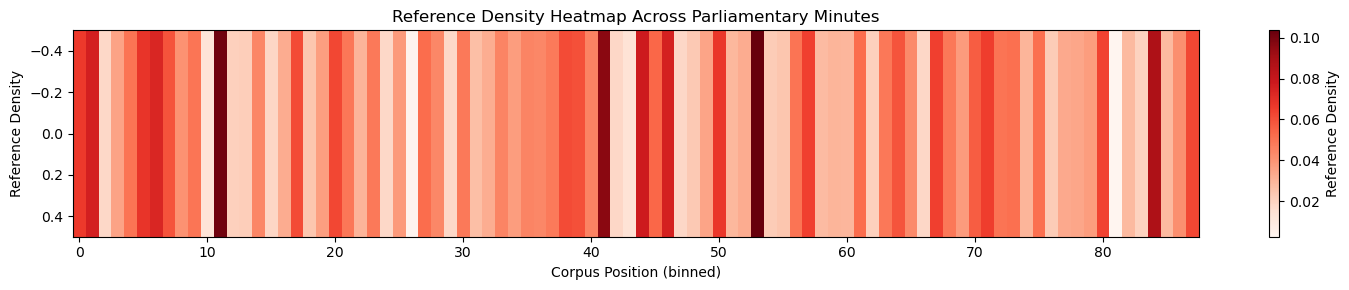

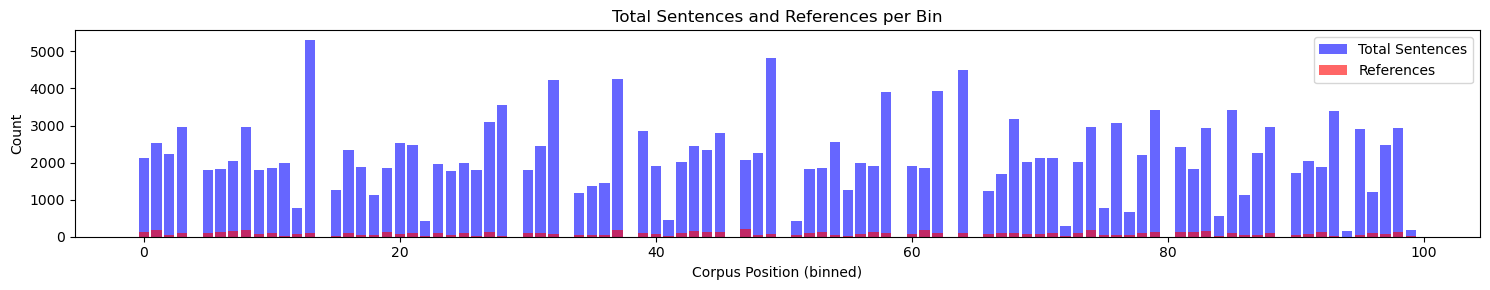

In [19]:
import matplotlib.pyplot as plt
bins = 100

# Create bins
df_all_sentences['bin'] = pd.cut(df_all_sentences['global_index'], bins=bins, labels=False)

# Calculate reference density per bin
bin_stats = df_all_sentences.groupby('bin').agg({
    'has_reference': ['sum', 'count']
}).round(3)

bin_stats.columns = ['references', 'total_sentences']
bin_stats['density'] = bin_stats['references'] / bin_stats['total_sentences']

# Plot heatmap
fig, ax = plt.subplots(figsize=(15, 3))

density_matrix = bin_stats['density'].values.reshape(1, -1)
im = ax.imshow(density_matrix, cmap='Reds', aspect='auto')

ax.set_xlabel('Corpus Position (binned)')
ax.set_ylabel('Reference Density')
ax.set_title('Reference Density Heatmap Across Parliamentary Minutes')

plt.colorbar(im, ax=ax, label='Reference Density')
plt.tight_layout()
plt.show()

# Show sentences per bin
plt.figure(figsize=(15, 3))
plt.bar(bin_stats.index, bin_stats['total_sentences'], color='blue', alpha=0.6, label='Total Sentences')
plt.bar(bin_stats.index, bin_stats['references'], color='red', alpha=0.6, label='References')
plt.xlabel('Corpus Position (binned)')
plt.ylabel('Count')
plt.title('Total Sentences and References per Bin')
plt.legend()
plt.tight_layout()
plt.show()

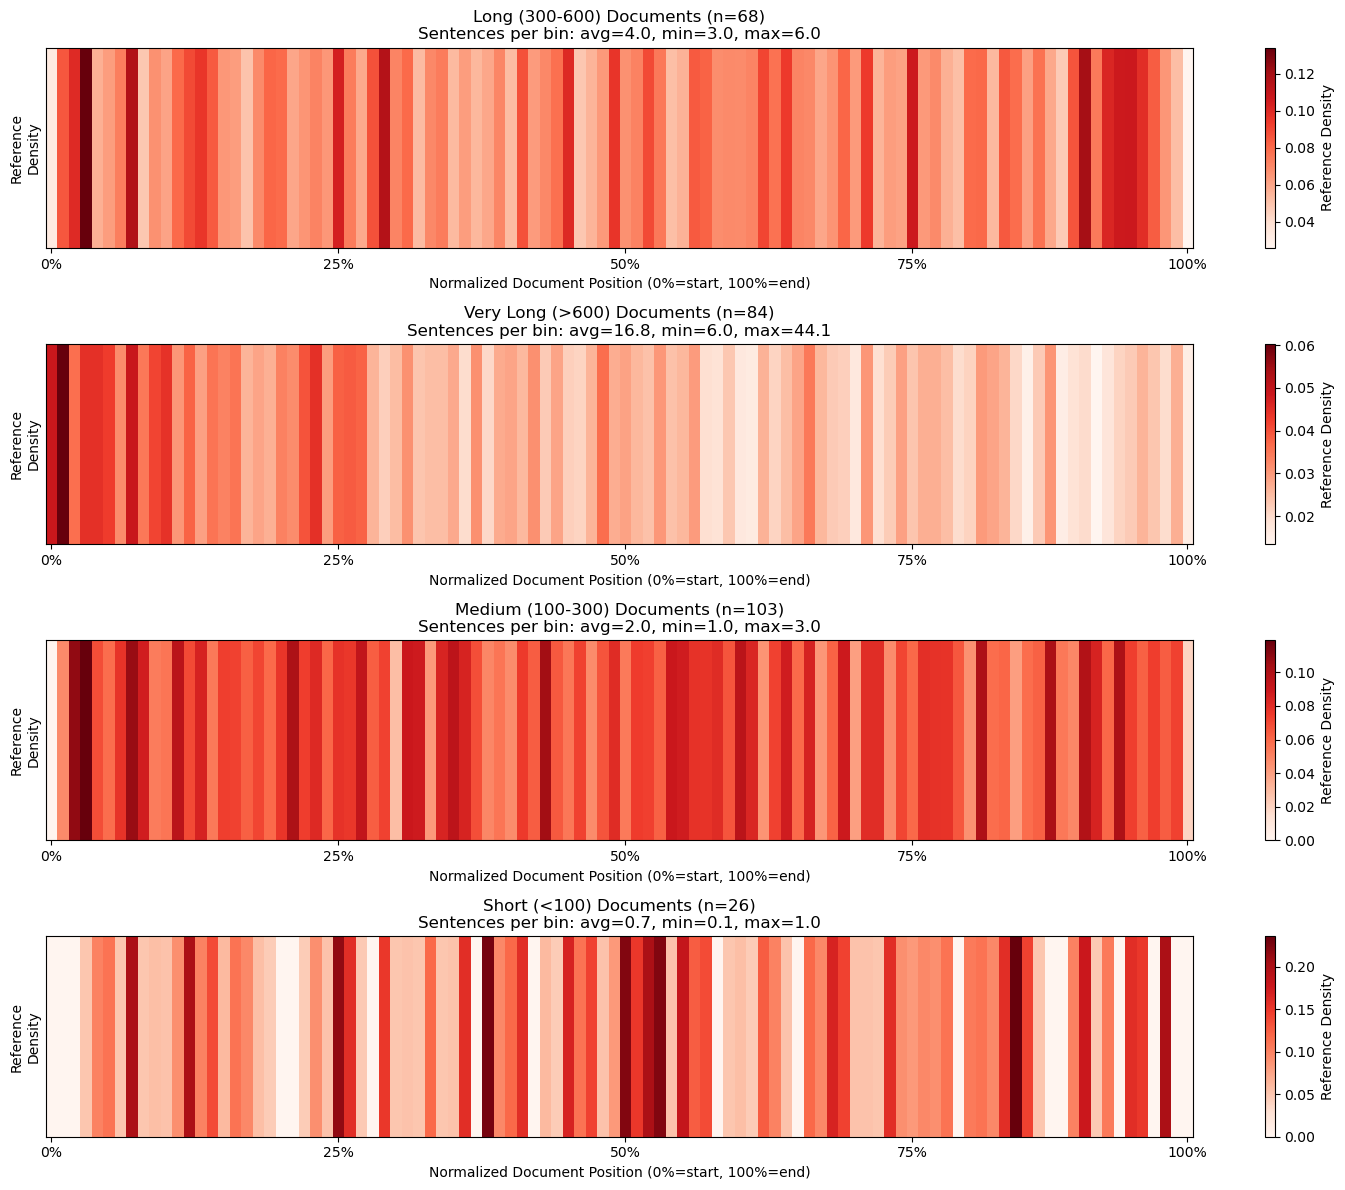

Document length distribution:
length_category
Long (300-600)       68
Medium (100-300)    103
Short (<100)         26
Very Long (>600)     84
Name: minute_id, dtype: int64

Sentences per bin by category:
Long (300-600):
  Document lengths: 302-595 sentences
  Sentences per bin: avg=4.0, min=3.0, max=6.0
Very Long (>600):
  Document lengths: 603-4407 sentences
  Sentences per bin: avg=16.8, min=6.0, max=44.1
Medium (100-300):
  Document lengths: 101-298 sentences
  Sentences per bin: avg=2.0, min=1.0, max=3.0
Short (<100):
  Document lengths: 12-99 sentences
  Sentences per bin: avg=0.7, min=0.1, max=1.0


In [67]:
import matplotlib.pyplot as plt
import numpy as np

bins = 100

# Calculate document lengths properly
doc_lengths = df_all_sentences.groupby('minute_id').size()

# Define length categories
def categorize_length(length):
    if length < 100:
        return 'Short (<100)'
    elif length < 300:
        return 'Medium (100-300)'
    elif length < 600:
        return 'Long (300-600)'
    else:
        return 'Very Long (>600)'

# Add length category to each sentence
df_all_sentences['doc_length'] = df_all_sentences['minute_id'].map(doc_lengths)
df_all_sentences['length_category'] = df_all_sentences['doc_length'].apply(
    categorize_length
)

# Create normalized position within each document (0-1 scale)
df_all_sentences['normalized_position'] = (
    df_all_sentences['sentence_index'] / (df_all_sentences['doc_length'] - 1)
).clip(0, 1)

# Create bins based on normalized position
df_all_sentences['norm_bin'] = pd.cut(
    df_all_sentences['normalized_position'], 
    bins=bins, 
    labels=False
)

# Get unique categories and create subplots
categories = df_all_sentences['length_category'].unique()
n_categories = len(categories)

fig, axes = plt.subplots(n_categories, 1, figsize=(15, 3 * n_categories))
if n_categories == 1:
    axes = [axes]

for i, category in enumerate(categories):
    # Filter data for this category
    category_data = df_all_sentences[
        df_all_sentences['length_category'] == category
    ]
    
    # Calculate bin statistics for this category
    bin_stats = category_data.groupby('norm_bin').agg({
        'has_reference': ['sum', 'count']
    }).round(3)
    
    bin_stats.columns = ['references', 'total_sentences']
    bin_stats['density'] = bin_stats['references'] / bin_stats['total_sentences']
    
    # Create density matrix (fill missing bins with 0)
    density_values = np.zeros(bins)
    for bin_idx in bin_stats.index:
        if not pd.isna(bin_idx):
            density_values[int(bin_idx)] = bin_stats.loc[bin_idx, 'density']
    
    density_matrix = density_values.reshape(1, -1)
    
    # Calculate sentences per bin for documents in this category
    category_doc_lengths = category_data.groupby('minute_id')['doc_length'].first()
    avg_doc_length = category_doc_lengths.mean()
    min_doc_length = category_doc_lengths.min()
    max_doc_length = category_doc_lengths.max()
    
    # Calculate how many sentences each bin represents
    avg_sentences_per_bin = avg_doc_length / bins
    min_sentences_per_bin = min_doc_length / bins
    max_sentences_per_bin = max_doc_length / bins
    
    # Plot heatmap
    im = axes[i].imshow(density_matrix, cmap='Reds', aspect='auto')
    
    # Set labels and title with sentence count info
    axes[i].set_xlabel('Normalized Document Position (0%=start, 100%=end)')
    axes[i].set_ylabel('Reference\nDensity')
    
    title = f'{category} Documents (n={len(category_data["minute_id"].unique())})\n'
    title += f'Sentences per bin: avg={avg_sentences_per_bin:.1f}, '
    title += f'min={min_sentences_per_bin:.1f}, max={max_sentences_per_bin:.1f}'
    
    axes[i].set_title(title)
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], label='Reference Density')
    
    # Set x-axis ticks to show meaningful positions
    tick_positions = [0, bins//4, bins//2, 3*bins//4, bins-1]
    tick_labels = ['0%', '25%', '50%', '75%', '100%']
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(tick_labels)
    
    # Remove y-axis ticks (single row heatmap)
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Print summary statistics
print("Document length distribution:")
print(df_all_sentences.groupby('length_category')['minute_id'].nunique().sort_index())

print("\nSentences per bin by category:")
for category in categories:
    category_data = df_all_sentences[
        df_all_sentences['length_category'] == category
    ]
    category_doc_lengths = category_data.groupby('minute_id')['doc_length'].first()
    
    avg_sentences_per_bin = category_doc_lengths.mean() / bins
    min_sentences_per_bin = category_doc_lengths.min() / bins
    max_sentences_per_bin = category_doc_lengths.max() / bins
    
    print(f"{category}:")
    print(f"  Document lengths: {category_doc_lengths.min()}-{category_doc_lengths.max()} sentences")
    print(f"  Sentences per bin: avg={avg_sentences_per_bin:.1f}, "
          f"min={min_sentences_per_bin:.1f}, max={max_sentences_per_bin:.1f}")

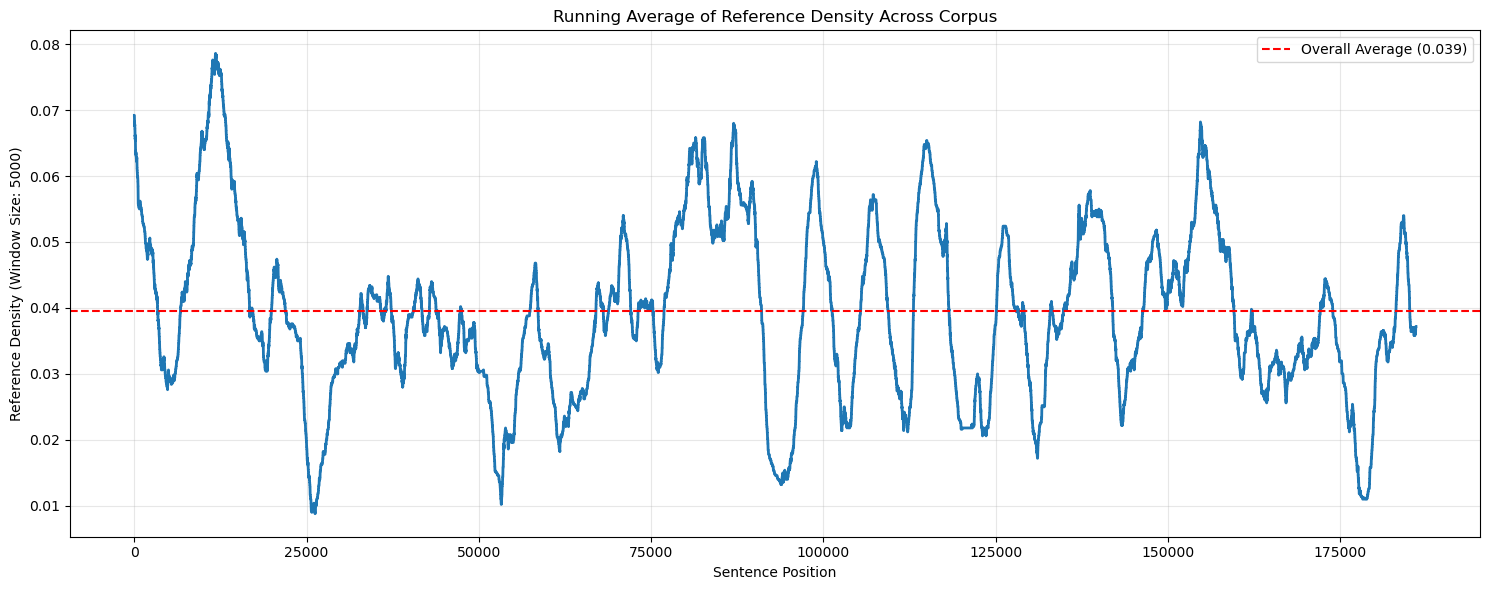

In [49]:
import numpy as np
window_size = 5000

ref_array = df_all_sentences['has_reference'].astype(int).values

# Calculate running average
running_avg = np.convolve(ref_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(15, 6))
plt.plot(running_avg, linewidth=2)
plt.axhline(y=np.mean(ref_array), color='red', linestyle='--', 
            label=f'Overall Average ({np.mean(ref_array):.3f})')
plt.xlabel('Sentence Position')
plt.ylabel(f'Reference Density (Window Size: {window_size})')
plt.title('Running Average of Reference Density Across Corpus')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

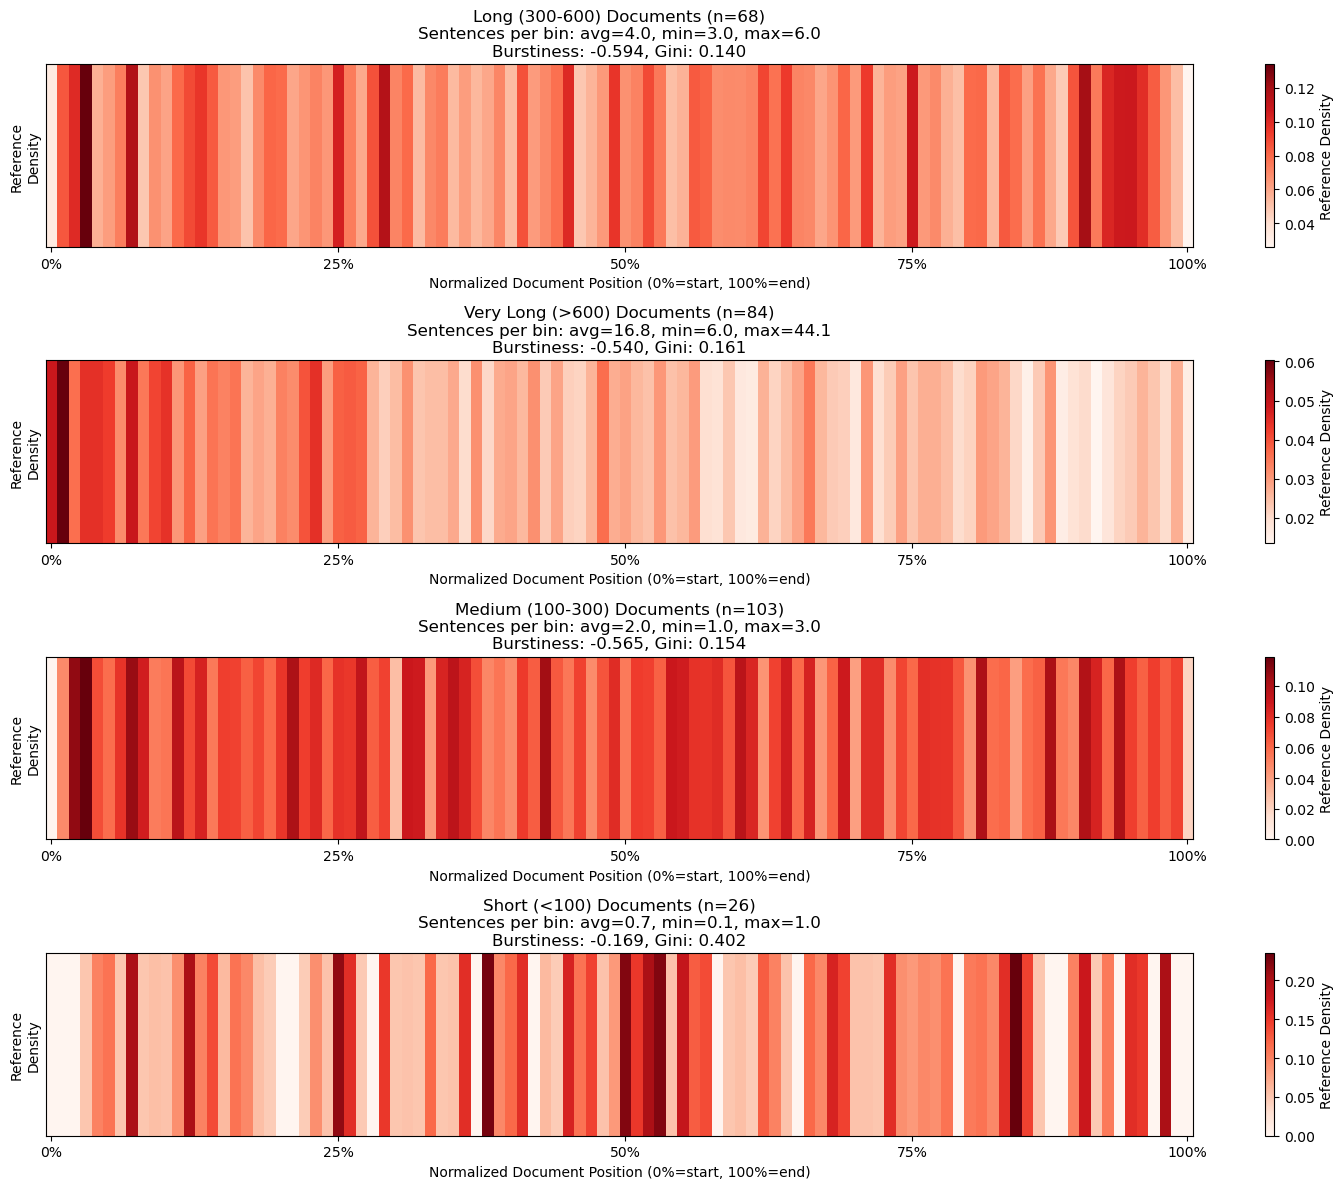

=== BURSTINESS METRICS ANALYSIS ===

Long (300-600):
  Burstiness Parameter (Goh & Barabási): -0.5943
    Range: [-1, 1], where 1 = maximum burstiness, 0 = random, -1 = regular
  Gini Coefficient: 0.1402
    Range: [0, 1], where 0 = perfect equality, 1 = maximum inequality
  Coefficient of Variation: 0.2545
    Higher values indicate more variability relative to mean
  Index of Dispersion: 0.0048
    >1 indicates overdispersion (clustering), <1 underdispersion
  Entropy-based Burstiness: 0.0069
    Range: [0, 1], where 1 = maximum burstiness, 0 = uniform distribution
  Peak-to-Mean Ratio: 1.8258
    Higher values indicate stronger peaks relative to average
  Autocorrelation (lag-1): 0.1521
    Range: [-1, 1], positive values indicate temporal clustering
  Density Stats: mean=0.0734, std=0.0187, max=0.1341

Very Long (>600):
  Burstiness Parameter (Goh & Barabási): -0.5397
    Range: [-1, 1], where 1 = maximum burstiness, 0 = random, -1 = regular
  Gini Coefficient: 0.1614
    Range: [0

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

bins = 100

# [Your existing preprocessing code remains the same...]
# Calculate document lengths properly
doc_lengths = df_all_sentences.groupby('minute_id').size()

def categorize_length(length):
    if length < 100:
        return 'Short (<100)'
    elif length < 300:
        return 'Medium (100-300)'
    elif length < 600:
        return 'Long (300-600)'
    else:
        return 'Very Long (>600)'

df_all_sentences['doc_length'] = df_all_sentences['minute_id'].map(doc_lengths)
df_all_sentences['length_category'] = df_all_sentences['doc_length'].apply(
    categorize_length
)

df_all_sentences['normalized_position'] = (
    df_all_sentences['sentence_index'] / (df_all_sentences['doc_length'] - 1)
).clip(0, 1)

df_all_sentences['norm_bin'] = pd.cut(
    df_all_sentences['normalized_position'], 
    bins=bins, 
    labels=False
)

# Burstiness Metrics Functions
def calculate_burstiness_metrics(densities):
    """Calculate various burstiness metrics for a density array"""
    densities = np.array(densities)
    densities = densities[~np.isnan(densities)]  # Remove NaN values
    
    if len(densities) == 0:
        return {}
    
    # 1. Gini Coefficient (inequality measure)
    def gini_coefficient(x):
        n = len(x)
        if n == 0:
            return 0
        x_sorted = np.sort(x)
        cumsum = np.cumsum(x_sorted)
        return (2 * np.sum((np.arange(1, n+1) * x_sorted))) / (n * cumsum[-1]) - (n + 1) / n
    
    # 2. Coefficient of Variation
    cv = np.std(densities) / np.mean(densities) if np.mean(densities) > 0 else 0
    
    # 3. Burstiness Parameter (Goh & Barabási, 2008)
    # B = (σ - μ) / (σ + μ) where σ is std dev and μ is mean
    mean_val = np.mean(densities)
    std_val = np.std(densities)
    burstiness_param = (std_val - mean_val) / (std_val + mean_val) if (std_val + mean_val) > 0 else 0
    
    # 4. Index of Dispersion (variance-to-mean ratio)
    index_dispersion = np.var(densities) / np.mean(densities) if np.mean(densities) > 0 else 0
    
    # 5. Entropy-based measure
    # Normalize densities to probabilities
    if np.sum(densities) > 0:
        probs = densities / np.sum(densities)
        entropy = -np.sum(probs * np.log2(probs + 1e-10))  # Add small value to avoid log(0)
        max_entropy = np.log2(len(probs))
        normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
        # Burstiness = 1 - normalized_entropy (high burstiness = low entropy)
        entropy_burstiness = 1 - normalized_entropy
    else:
        entropy_burstiness = 0
    
    # 6. Peak-to-Mean Ratio
    peak_to_mean = np.max(densities) / np.mean(densities) if np.mean(densities) > 0 else 0
    
    # 7. Autocorrelation at lag 1 (temporal clustering)
    if len(densities) > 1:
        autocorr = np.corrcoef(densities[:-1], densities[1:])[0, 1]
        autocorr = 0 if np.isnan(autocorr) else autocorr
    else:
        autocorr = 0
    
    return {
        'gini_coefficient': gini_coefficient(densities),
        'coefficient_variation': cv,
        'burstiness_parameter': burstiness_param,
        'index_dispersion': index_dispersion,
        'entropy_burstiness': entropy_burstiness,
        'peak_to_mean_ratio': peak_to_mean,
        'autocorrelation_lag1': autocorr,
        'mean_density': mean_val,
        'std_density': std_val,
        'max_density': np.max(densities),
        'min_density': np.min(densities)
    }

# [Your existing plotting code...]
categories = df_all_sentences['length_category'].unique()
n_categories = len(categories)

fig, axes = plt.subplots(n_categories, 1, figsize=(15, 3 * n_categories))
if n_categories == 1:
    axes = [axes]

# Store burstiness metrics for each category
burstiness_results = {}

for i, category in enumerate(categories):
    category_data = df_all_sentences[
        df_all_sentences['length_category'] == category
    ]
    
    bin_stats = category_data.groupby('norm_bin').agg({
        'has_reference': ['sum', 'count']
    }).round(3)
    
    bin_stats.columns = ['references', 'total_sentences']
    bin_stats['density'] = bin_stats['references'] / bin_stats['total_sentences']
    
    # Calculate burstiness metrics
    densities = []
    for bin_idx in range(bins):
        if bin_idx in bin_stats.index:
            densities.append(bin_stats.loc[bin_idx, 'density'])
        else:
            densities.append(0)
    
    burstiness_metrics = calculate_burstiness_metrics(densities)
    burstiness_results[category] = burstiness_metrics
    
    # Create density matrix
    density_matrix = np.array(densities).reshape(1, -1)
    
    # Calculate sentences per bin
    category_doc_lengths = category_data.groupby('minute_id')['doc_length'].first()
    avg_sentences_per_bin = category_doc_lengths.mean() / bins
    min_sentences_per_bin = category_doc_lengths.min() / bins
    max_sentences_per_bin = category_doc_lengths.max() / bins
    
    # Plot heatmap
    im = axes[i].imshow(density_matrix, cmap='Reds', aspect='auto')
    
    axes[i].set_xlabel('Normalized Document Position (0%=start, 100%=end)')
    axes[i].set_ylabel('Reference\nDensity')
    
    title = f'{category} Documents (n={len(category_data["minute_id"].unique())})\n'
    title += f'Sentences per bin: avg={avg_sentences_per_bin:.1f}, '
    title += f'min={min_sentences_per_bin:.1f}, max={max_sentences_per_bin:.1f}\n'
    title += f'Burstiness: {burstiness_metrics["burstiness_parameter"]:.3f}, '
    title += f'Gini: {burstiness_metrics["gini_coefficient"]:.3f}'
    
    axes[i].set_title(title)
    
    plt.colorbar(im, ax=axes[i], label='Reference Density')
    
    tick_positions = [0, bins//4, bins//2, 3*bins//4, bins-1]
    tick_labels = ['0%', '25%', '50%', '75%', '100%']
    axes[i].set_xticks(tick_positions)
    axes[i].set_xticklabels(tick_labels)
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Print detailed burstiness metrics
print("=== BURSTINESS METRICS ANALYSIS ===\n")
for category in categories:
    metrics = burstiness_results[category]
    print(f"{category}:")
    print(f"  Burstiness Parameter (Goh & Barabási): {metrics['burstiness_parameter']:.4f}")
    print(f"    Range: [-1, 1], where 1 = maximum burstiness, 0 = random, -1 = regular")
    print(f"  Gini Coefficient: {metrics['gini_coefficient']:.4f}")
    print(f"    Range: [0, 1], where 0 = perfect equality, 1 = maximum inequality")
    print(f"  Coefficient of Variation: {metrics['coefficient_variation']:.4f}")
    print(f"    Higher values indicate more variability relative to mean")
    print(f"  Index of Dispersion: {metrics['index_dispersion']:.4f}")
    print(f"    >1 indicates overdispersion (clustering), <1 underdispersion")
    print(f"  Entropy-based Burstiness: {metrics['entropy_burstiness']:.4f}")
    print(f"    Range: [0, 1], where 1 = maximum burstiness, 0 = uniform distribution")
    print(f"  Peak-to-Mean Ratio: {metrics['peak_to_mean_ratio']:.4f}")
    print(f"    Higher values indicate stronger peaks relative to average")
    print(f"  Autocorrelation (lag-1): {metrics['autocorrelation_lag1']:.4f}")
    print(f"    Range: [-1, 1], positive values indicate temporal clustering")
    print(f"  Density Stats: mean={metrics['mean_density']:.4f}, "
          f"std={metrics['std_density']:.4f}, max={metrics['max_density']:.4f}")
    print()